# Softmax回归的从零开始实现

In [84]:
import torch 
from IPython import display
from d2l import torch as d2l

In [85]:
batch_size = 256
train_iter, test_iter  = d2l.load_data_fashion_mnist(batch_size)

## 1. 初始化模型参数

一个图片是28 * 28，这里直接展平，后面才讨论共建结构的特征。

In [86]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(size=(num_outputs,), requires_grad=True)

## 2. 定义softmax操作

In [87]:
# 这里还是把X看作一个大的输入，然后X的shape可能是n * d 
# 这样就需要考虑一下维度的问题 
# 这里我发现一定要keepdim，否则会出错的
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True) # dim: dimension to reduce
    return X_exp / partition

In [88]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.0548, 0.2057, 0.0409, 0.6710, 0.0276],
         [0.4102, 0.1600, 0.1134, 0.2186, 0.0978]]),
 tensor([1.0000, 1.0000]))

## 3. 定义模型

In [89]:
# TODO: 这里我写的和书上不太一样
# 其实就是 有没有转置
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 4. 定义损失函数

In [90]:
y = torch.tensor([0, 2]) # 2 sample, 分别属于第0类和第2类
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

In [91]:
y_hat[range(len(y)), y]
# range(len(y)) 就是每一行我都要取（针对每一个样本）
# 后面那个用y， 就是第一个样本我是0类取0的那个概率，第二个样本是2类

tensor([0.1000, 0.5000])

In [92]:
# 这样一行代码就可以搞定实现交叉熵函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [93]:
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 5. 分类精度

In [94]:
def accuracy(y_hat, y):
    """ 计算预测正确的数量 """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())

In [95]:
# 我们来想一下上面的代码应该怎么解释
# 首先 这里y_hat是一个二维，y是一个一维的
# y_hat.shape > 1说明是2维
# y_hat.shape[1] > 1说明是二维而且是真正的二维
# 如果y_hat是一个真正的矩阵
# y_hat = y_hat.argmax(axis=1) 变成一个一维的，每一个就是预测的类别

# 最后return的类型转换 不是很明白。。。

In [96]:
accuracy(y_hat, y) / len(y)

0.5

In [97]:
class Accumulator:
    """ 在n个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [98]:
# 对于任意的数据迭代器data_iter可以访问的数据集，我们可以评估在任意模型上的精度
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数和预测总数
    with torch.no_grad():
        for X, y in data_iter:
            # print(X.shape)
            # print(y.shape)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [99]:
evaluate_accuracy(net, test_iter)

0.0672

## 6. 训练

In [102]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3) # 训练损失总和，训练准确度总和，样本数
    for X, y in train_iter:
        # 计算梯度并且更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [104]:
# 搞一个类来做可视化，这个不是那么的重要

class Animator: 
    """ 在动画中绘制数据 """
    
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * nrows == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        )
        self.X, self.Y, self.fmts = None, None, fmts 
    
    
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [105]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,updater):
    """ 训练模型 """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc 
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [106]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

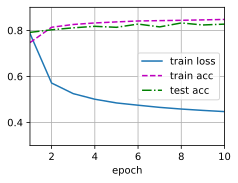

In [107]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 7. 预测

In [109]:
def predict_ch3(net, test_iter, n=6):
    """ 预测标签 """
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n]
    )
    
predict_ch3(net, test_iter, 100)